# Lab:  Nonlinear Least Squares for Modeling Materials

In this lab, we will explore gradient descent on nonlinear least squares.  

Suppose we wish to fit a model of the form,

     yhat ~= f(x,w)
     
where `x` is a vector of features, `w` is a vector of parameters and `f` is a nonlinear function of `w`.  Often we find the parameters `w` that minimize a squared-error cost of the form 

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This problem is known as nonlinear least-squares (NLLS).  In general, this optimization problem has no closed-form expression, and so gradient descent is widely used.  

In this lab, we will apply NLLS to the physical modeling of materials.  Specifically, we will estimate parameters in a model for the expansion of copper as a function of temperature.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets appropriate for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot `y` vs. `x`. 

Text(0, 0.5, 'y')

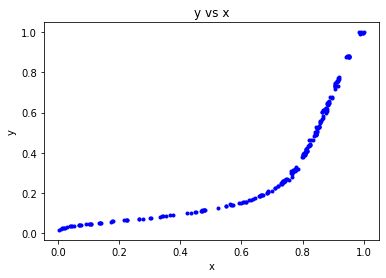

In [3]:
# TODO
# x0 = ...
# y0 = ...
# x = x0/np.max(x0)
# y = y0/np.max(y0)
# plt.plot(...)
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y,'.b')
plt.title("y vs x")
plt.xlabel("x")
plt.ylabel("y")

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

Text(0, 0.5, 'yn')

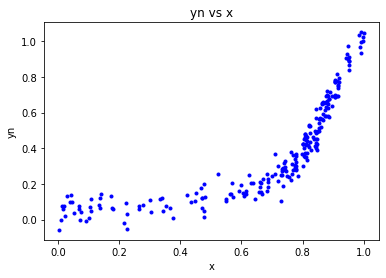

In [4]:
# TODO
# yn = y + ...
yn = y + np.random.normal(0,0.05,y.shape)
plt.plot(x,yn,'.b')
plt.title("yn vs x")
plt.xlabel("x")
plt.ylabel("yn")

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
# xtr, xts, ytr, yts = ...
xtr, xts, ytr, yts = train_test_split(x, yn, test_size= 0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]`, so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    # a = ...
    # b = ...
    a = w[0:d+1]
    b = w[d+1:]
    
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    # yhat = ...
    yhat = np.polyval(np.flip(a),x)/(np.polyval(np.append(np.flip(b),1),x))
    return yhat

When we fit with a nonlinear model, most methods only obtain convergence to a local minimum.  For that local minimum to be the global minimum, we need a good initial condition.  For a rational model, one way to get a good initialization is to realize that if

    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
then

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can initially solve for the parameters `w = [a,b]` using linear regression with the features

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ].

In [7]:
d = 3
from sklearn import linear_model

# TODO.  Create the transformed feature matrix
# Z = ...
Z = np.zeros((xtr.size,6))
for i in range(xtr.size):
    Z[i,:] = [xtr[i]**1, xtr[i]**2, xtr[i]**3, ytr[i]*xtr[i]**1, ytr[i]*xtr[i]**2, ytr[i]*xtr[i]**3]

# TODO.  Fit with parameters with linear regression
# regr = LinearRegression()
# regr.fit(...)
regr = linear_model.LinearRegression()
regr.fit(Z,ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# winit = ...
#winit = np.append(regr.coef_, regr.intercept_)
coefa = np.append([regr.intercept_],regr.coef_[:d])
coefb = -regr.coef_[d:]
winit = np.append(coefa,coefb)
print(winit)

[ 0.08070008 -0.41008586  0.50381886 -0.1670677  -5.39921383  8.1065773
 -3.71186947]


Now plot the predicted value `yhat` versus `x` using your initial parameter estimate `winit`.  Use 1000 values of `x` uniformly spaced over the interval `[0,1]`.  On the same plot, superimpose the points `(xts,yts)`.  You will see that the prediction curve has some singularities.

Text(0, 0.5, 'y')

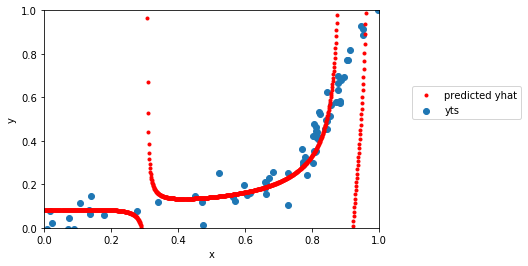

In [8]:
# TODO
# xp = ...
# yhat = ...
# plot(...)
xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat,'.r', label = "predicted yhat")
plt.scatter(xts,yts, label = "yts")
plt.legend(bbox_to_anchor=(1.1,0.65), loc='upper left', borderaxespad=0.)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("x")
plt.ylabel("y")

The problem with the prediction curve is that the denominator in our polynomial model for `yhat` goes to zero at certain values of `x` in `[0,1]`.  As a result, some of the `z` features become correlated, and the least-squares fit for `winit` includes relatively large coefficient values. To avoid this problem, we can use Ridge regression in an effort to keep the `winit` parameters closer to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-2`. You should see a much better (but not perfect) fit.

Text(0, 0.5, 'y')

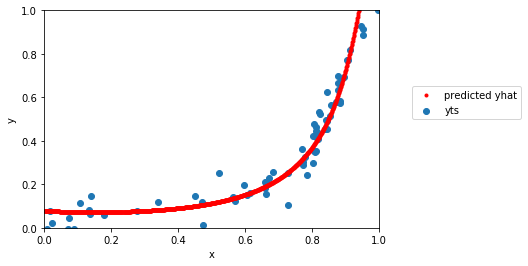

In [9]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-3)
# regr.fit(...)
regr = Ridge(alpha=1e-2)
regr.fit(Z,ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...
#winit = np.append(regr.coef_, regr.intercept_)
coefa = np.append([regr.intercept_],regr.coef_[:d])
coefb = -regr.coef_[d:]
winit = np.append(coefa,coefb)

# TODO
# Plot the results as above.
xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat,'.r', label = "predicted yhat")
plt.scatter(xts,yts, label = "yts")
plt.legend(bbox_to_anchor=(1.1,0.65), loc='upper left', borderaxespad=0.)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("x")
plt.ylabel("y")

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate of the weights `w`.  Complete the construction of the following function, which is used to compute the cost

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w,x,y):
          
    # TODO.  Parse w
    # a = ...
    # b = ...
    a = w[0:d+1]
    b = w[d+1:]
    
    # TODO.  Znum[i,j] = x[i]**j
    Znum = np.zeros((x.size,4))
    for j in range(4):
        Znum[:,j] = x[:]**j
    
    # TODO.  Zden[i,j] = x[i]**(j+1)
    Zden = np.zeros((x.size,3))
    for j in range(3):
        Zden[:,j] = x[:]**(j+1)
        
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    yhat = Znum.dot(a)/(1+Zden.dot(b))
    
    # TODO.  Compute loss
    # f = ...
    f = 0.5*np.sum((y-yhat)**2)
    
    # TODO.  Compute gradients
    df_dyhat = yhat-y
    gdw0 = np.sum(df_dyhat*Znum[:,0]/(1+Zden.dot(b)))
    gdw1 = np.sum(df_dyhat*Znum[:,1]/(1+Zden.dot(b)))
    gdw2 = np.sum(df_dyhat*Znum[:,2]/(1+Zden.dot(b)))
    gdw3 = np.sum(df_dyhat*Znum[:,3]/(1+Zden.dot(b)))
    gdw4 = np.sum(-df_dyhat*Zden[:,0]*Znum.dot(a)/(1+Zden.dot(b))**2)
    gdw5 = np.sum(-df_dyhat*Zden[:,1]*Znum.dot(a)/(1+Zden.dot(b))**2)
    gdw6 = np.sum(-df_dyhat*Zden[:,2]*Znum.dot(a)/(1+Zden.dot(b))**2)
    fgrad = np.array([gdw0, gdw1, gdw2, gdw3, gdw4, gdw5, gdw6])
    
    return f, fgrad


Now, test your gradient computation:
* Set `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take a `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO
step = 1e-6
w0 = winit
w1 = w0 + step*np.random.randn(7)
f0, fgrad0 = feval(w0,xtr,ytr)
f1, fgrad0 = feval(w1,xtr,ytr)
df_est = fgrad0.dot(w1-w0)
print(f1-f0)
print(df_est)

-0.0007102231713134177
-0.0007097367234178338


+021..............................................................................................22## Implement gradient descent

We will now try to minimize the loss function using gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases but does not fully converge after 10000 iterations.

Text(0, 0.5, 'loss')

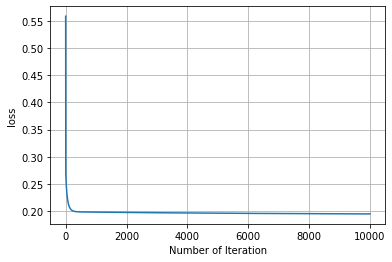

In [12]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6
hist = {'w':[], 'f':[]}
w0 = winit

for it in range(nit):

    # Evaluate the function and gradient
    f0, fgrad0 = feval(w0, xtr, ytr)

    # Take a gradient step
    w0 = w0 - step*fgrad0

     # Save history
    hist['f'].append(f0)
    hist['w'].append(w0)

# Convert to numpy arrays
for elem in ('f', 'w'):
    hist[elem] = np.array(hist[elem])
    
fgd = hist['f']
wgd = hist['w']

plt.plot(fgd)
plt.grid()
plt.xlabel('Number of Iteration')
plt.ylabel('loss')

Now try to get a faster convergence using adaptive step-size via the Armijo rule. Implement Armijo gradient descent.  Let `fadapt[it]` be the loss value that it attains on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see some improvement, but also some lingering problems.

Text(0, 0.5, 'Loss')

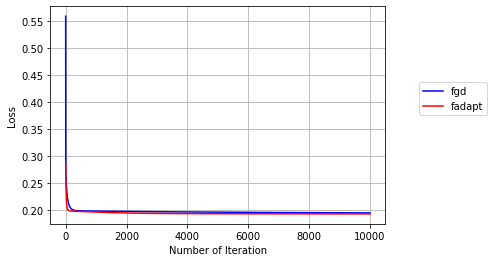

In [13]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
w0 = winit
f0, fgrad0 = feval(w0, xtr, ytr)
hist = {'step':[], 'w':[], 'f':[]}

for it in range(nit):

    # Take a gradient step
    w1 = w0 - step*fgrad0

    # Evaluate the test point by computing the objective function, f1,
    # at the test point and the predicted decrease, df_est
    f1, fgrad1 = feval(w1, xtr, ytr)
    df_est = fgrad0.dot(w1-w0)

    # Check if test point passes the Armijo condition
    alpha = 0.5
    if (f1-f0 < alpha*df_est) and (f1 < f0):
        # If descent is sufficient, accept the point and increase the
        # learning rate
        step = step*2
        f0 = f1
        fgrad0 = fgrad1
        w0 = w1
    else:
        # Otherwise, decrease the learning rate
        step = step/2            

    # Save history
    hist['f'].append(f0)
    hist['step'].append(step)
    hist['w'].append(w0)

# Convert to numpy arrays
for elem in ('f', 'step', 'w'):
    hist[elem] = np.array(hist[elem])
    
fadapt = hist['f']
wadapt = hist['w']

plt.plot(fgd, 'b', label='fgd')
plt.plot(fadapt, 'r', label='fadapt')
plt.legend(bbox_to_anchor=(1.1,0.65), loc='upper left', borderaxespad=0.)
plt.grid()
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')

Using the final estimate for `w` from the adaptive step-size approach, plot the predicted value of `yhat` vs. `x` for 1000 values of `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot the test data, `yts` vs. `xts`.  You should see that gradient descent was able to improve the prediction model, although the initial prediction model was not too bad.

(0, 1.5)

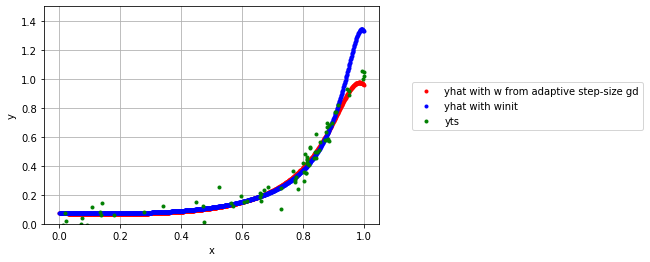

In [14]:
# TODO
# xp = np.linspace(...)
# yhat = ...
# plot(...)
xp = np.linspace(0,1,1000)
yhat = predict(wadapt[9999,:],xp)
plt.plot(xp,yhat, '.r', label = 'yhat with w from adaptive step-size gd')
plt.plot(xp,predict(winit,xp), '.b', label = 'yhat with winit')
plt.plot(xts,yts, '.g', label = 'yts')
plt.grid()
plt.legend(bbox_to_anchor=(1.1,0.65), loc='upper left', borderaxespad=0.)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0, 1.5])

## Momentum Gradient Descent

This section is optional.

One way to improve gradient descent is to use *momentum*.  With momentum, the gradient-descent update rule becomes:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that the update direction `z` is the sum of the gradient `fgrad` and the previous update direction `z`, which tends to keep the algorithm moving in the same direction (instead of randomly changing directions, as it would if `z=fgrad`).  Implement momentum gradient-descent with `beta = 0.99` and `step=1e-5`.  Compare the convergence of this approach to plain gradient descent and the adaptive stepsize version.  

(0, 20)

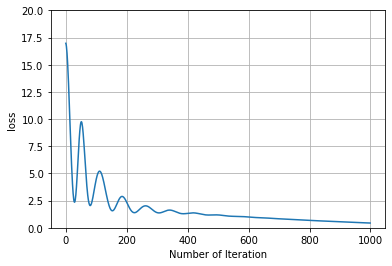

In [15]:
# TODO
nit = 1000
step = 1e-5
beta = 0.99
hist = {'w':[], 'f':[]}
w0 = np.zeros(np.shape(winit))
z = np.zeros(np.shape(winit))

for it in range(nit):

    # Evaluate the function and gradient
    f0, fgrad0 = feval(w0, xtr, ytr)

    # Calcuate z
    z = beta*z + fgrad0
    
    # Take a gradient step
    w0 = w0 - step*z

     # Save history
    hist['f'].append(f0)
    hist['w'].append(w0)


# Convert to numpy arrays
for elem in ('f', 'w'):
    hist[elem] = np.array(hist[elem])
    
fgdmom = hist['f']
wgdmom = hist['w']

plt.plot(fgdmom)
plt.grid()
plt.xlabel('Number of Iteration')
plt.ylabel('loss')
plt.ylim([0,20])

(0, 1.5)

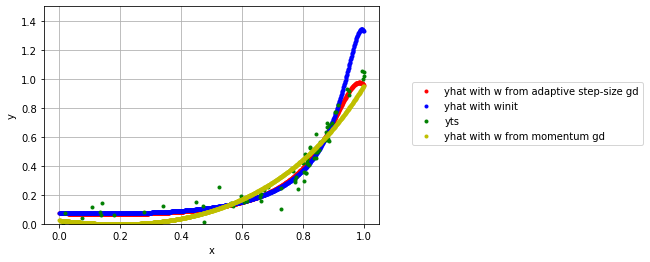

In [16]:
# TODO
# plot yhat vs. x
xp = np.linspace(0,1,1000)
yhat = predict(wadapt[9999,:],xp)
yhatmom = predict(wgdmom[999,:],xp)
plt.plot(xp,yhat, '.r', label = 'yhat with w from adaptive step-size gd')
plt.plot(xp,predict(winit,xp), '.b', label = 'yhat with winit')
plt.plot(xts,yts, '.g', label = 'yts')
plt.plot(xp,yhatmom, '.y', label = 'yhat with w from momentum gd')
plt.grid()
plt.legend(bbox_to_anchor=(1.1,0.65), loc='upper left', borderaxespad=0.)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0, 1.5])

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.